In [8]:
"""Cell 1: Generate a ground truth grid."""

import sys
sys.path.insert(0, "..")

import numpy as np
import torch
import matplotlib.pyplot as plt
from data.data_processing import get_nfv_dataset, preprocess_wavefront_data

# Grid parameters
nx, nt = 50, 500
dx, dt = 0.02, 0.004
max_steps = 10  # number of pieces in piecewise-constant IC

np.random.seed(42)
grids, ic_xs, ic_ks = get_nfv_dataset(
    n_samples=5, nx=nx, nt=nt, dx=dx, dt=dt,
    max_steps=max_steps, only_shocks=False,
)
processed = preprocess_wavefront_data(grids, nx, nt, dx, dt)

# Pick one sample
sample_idx = 4
input_data, target_grid = processed[sample_idx]  # target_grid: (1, nt, nx)
grid = target_grid.squeeze(0)  # (nt, nx)

# Coordinate arrays for plotting
x = np.arange(nx) * dx
t = np.arange(nt) * dt

print(f"Grid shape: {grid.shape}")
print(f"x range: [{x[0]:.3f}, {x[-1]:.3f}], t range: [{t[0]:.3f}, {t[-1]:.3f}]")
print(f"Density range: [{grid.min():.3f}, {grid.max():.3f}]")

2it [00:00,  2.40it/s]                       

Grid shape: torch.Size([500, 50])
x range: [0.000, 0.980], t range: [0.000, 1.996]
Density range: [0.074, 0.863]


In [ ]:
"""Cell 2: Binary entropy mask vs distance-to-nearest-shock.

Three-column visualisation:
  1. Ground truth density
  2. Binary Lax entropy condition (is_shock boolean mask)
  3. Distance to nearest shock interface (continuous field)
"""

# Pick one sample
sample_idx = 3
input_data, target_grid = processed[sample_idx]  # target_grid: (1, nt, nx)
grid = target_grid.squeeze(0)  # (nt, nx)

# Coordinate arrays for plotting
x = np.arange(nx) * dx
t = np.arange(nt) * dt

# --- Entropy condition at every interface ---
rho_left = grid[:, :-1].numpy()   # (nt, nx-1)
rho_right = grid[:, 1:].numpy()   # (nt, nx-1)

char_left = 1.0 - 2.0 * rho_left
char_right = 1.0 - 2.0 * rho_right
shock_speed = 1.0 - rho_left - rho_right

# Binary shock mask
is_shock = (char_left > shock_speed) & (shock_speed > char_right)  # (nt, nx-1)

# Interface midpoint x-coordinates
x_mid = (x[:-1] + x[1:]) / 2  # (nx-1,)

# --- Distance to nearest shock interface (continuous field) ---
# For each interface at each timestep, compute min distance to any shock interface
dist_to_shock = np.full_like(rho_left, fill_value=np.inf, dtype=np.float64)
for ti in range(nt):
    shock_positions = x_mid[is_shock[ti]]
    if len(shock_positions) > 0:
        # |x_mid_j - x_shock_k| for all j, k; take min over k
        dists = np.abs(x_mid[:, None] - shock_positions[None, :])  # (nx-1, n_shocks)
        dist_to_shock[ti] = dists.min(axis=1)
    else:
        dist_to_shock[ti] = 1.0  # no shocks at this timestep

# --- Plot: 3 columns ---
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# 1) Ground truth density
im0 = axes[0].pcolormesh(x, t, grid.numpy(), shading="auto", cmap="viridis")
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_title("Ground truth density")
fig.colorbar(im0, ax=axes[0], label=r"$\rho$")

# 2) Binary entropy condition
im1 = axes[1].pcolormesh(
    x_mid, t, is_shock.astype(float),
    shading="auto", cmap="hot", vmin=0, vmax=1,
)
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_title("Binary entropy mask")
fig.colorbar(im1, ax=axes[1], label="is_shock")

# 3) Distance to nearest shock (continuous)
im2 = axes[2].pcolormesh(
    x_mid, t, dist_to_shock,
    shading="auto", cmap="hot_r",
    vmin=0, vmax=0.3,
)
axes[2].set_xlabel("x")
axes[2].set_ylabel("t")
axes[2].set_title("Distance to nearest shock interface (continuous)")
fig.colorbar(im2, ax=axes[2], label=r"$d_{\min}$")

fig.tight_layout()
plt.show()

print(f"Binary shocks: {is_shock.sum()} interfaces out of {is_shock.size}")
print(f"Distance range: [{dist_to_shock[dist_to_shock < np.inf].min():.6f}, {dist_to_shock[dist_to_shock < np.inf].max():.6f}]")

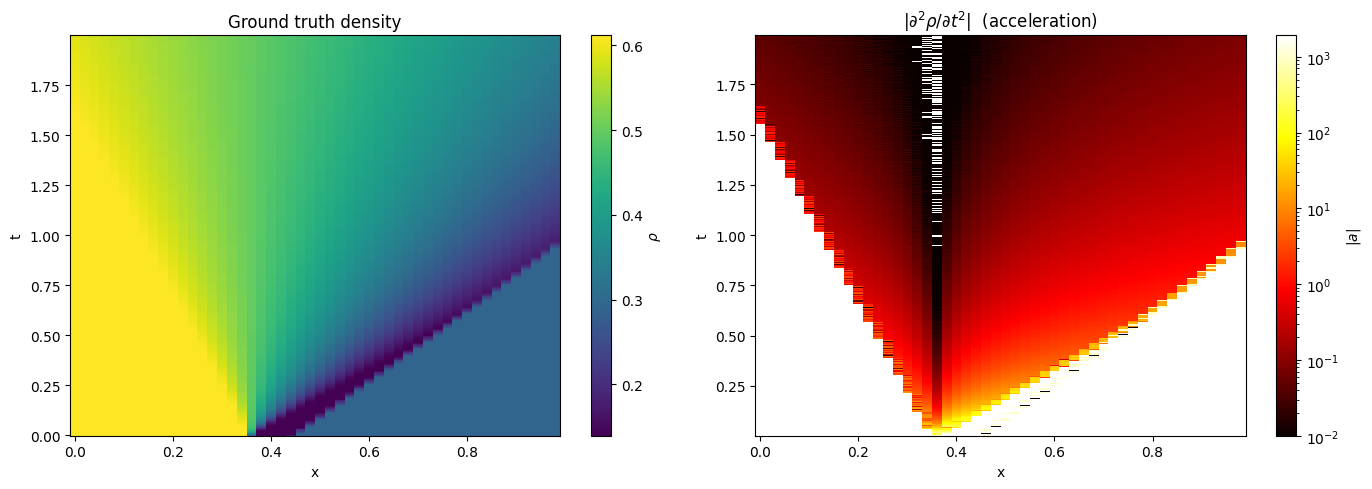

Acceleration shape: torch.Size([498, 50])
Max |accel|: 1908.13, Mean |accel|: 4.87


In [2]:
"""Cell 2: Acceleration grid vs ground truth."""

from losses.acceleration import compute_acceleration

# Compute acceleration: (1, nt, nx) -> (1, nt-2, nx)
accel = compute_acceleration(grid.unsqueeze(0), dt).squeeze(0)  # (nt-2, nx)

# Interior time array (drops first and last time step)
t_interior = t[1:-1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ground truth density
im0 = axes[0].pcolormesh(x, t, grid.numpy(), shading="auto", cmap="viridis")
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_title("Ground truth density")
fig.colorbar(im0, ax=axes[0], label=r"$\rho$")

# Acceleration (log scale of absolute value for visibility)
accel_abs = accel.abs().numpy()
im1 = axes[1].pcolormesh(
    x, t_interior, accel_abs,
    shading="auto", cmap="hot",
    norm=plt.matplotlib.colors.LogNorm(
        vmin=max(accel_abs[accel_abs > 0].min(), 1e-2),
        vmax=accel_abs.max(),
    ),
)
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_title(r"$|\partial^2 \rho / \partial t^2|$  (acceleration)")
fig.colorbar(im1, ax=axes[1], label=r"$|a|$")

fig.tight_layout()
plt.show()

print(f"Acceleration shape: {accel.shape}")
print(f"Max |accel|: {accel_abs.max():.2f}, Mean |accel|: {accel_abs.mean():.2f}")

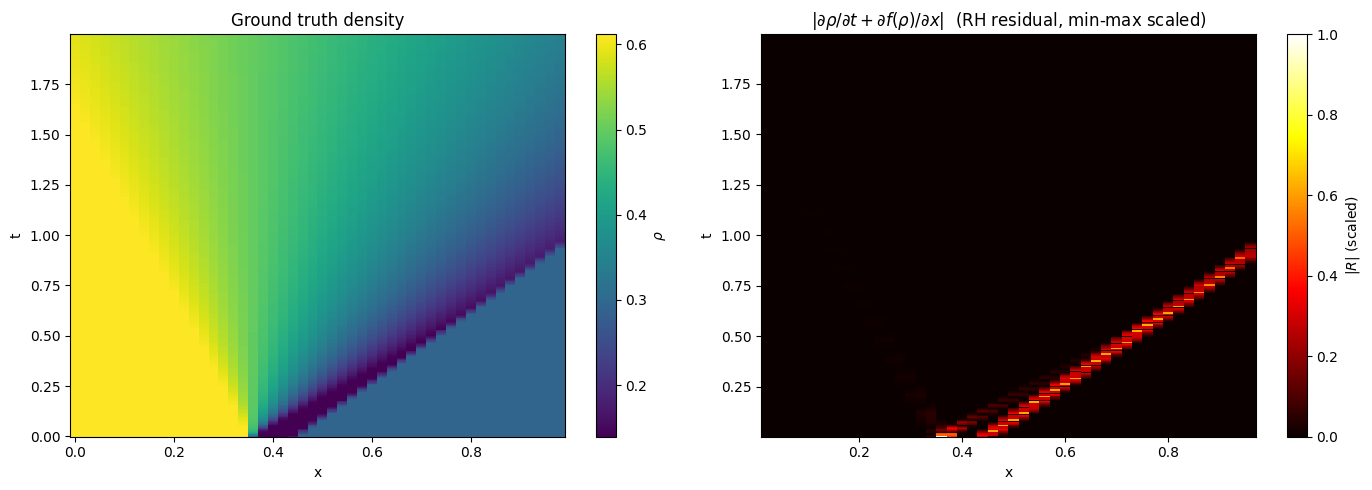

RH residual shape: torch.Size([498, 48])
Max |R|: 5.7765, Mean |R|: 0.0413
Scaled range: [0.0000, 1.0000]


In [3]:
"""Cell 3: RH / conservation residual grid vs ground truth.

At each interior cell we compute the PDE residual:
    R = d rho / dt + d f(rho) / dx
where f(rho) = rho * (1 - rho)  (Greenshields flux).

In smooth regions R ~ 0. At shocks the pointwise PDE breaks down
and R is large -- these are exactly the locations where the
Rankine-Hugoniot jump condition governs the solution.
"""

from losses.pde_residual import compute_pde_residual

min_max_scale_rh = True  # Set to False to plot raw absolute values

# Compute RH / conservation residual: (1, nt, nx) -> (1, nt-2, nx-2)
rh_res = compute_pde_residual(grid.unsqueeze(0), dt, dx).squeeze(0)  # (nt-2, nx-2)

# Interior coordinate arrays
x_interior = x[1:-1]
t_interior = t[1:-1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ground truth density
im0 = axes[0].pcolormesh(x, t, grid.numpy(), shading="auto", cmap="viridis")
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_title("Ground truth density")
fig.colorbar(im0, ax=axes[0], label=r"$\rho$")

# RH residual
rh_abs = rh_res.abs().numpy()
if min_max_scale_rh:
    rh_min, rh_max = rh_abs.min(), rh_abs.max()
    rh_plot = (rh_abs - rh_min) / (rh_max - rh_min)
    plot_kwargs = dict(vmin=0, vmax=1)
    cbar_label = r"$|R|$ (scaled)"
    title_suffix = "  (RH residual, min-max scaled)"
else:
    rh_plot = rh_abs
    plot_kwargs = {}
    cbar_label = r"$|R|$"
    title_suffix = "  (RH residual)"
im1 = axes[1].pcolormesh(
    x_interior, t_interior, rh_plot,
    shading="auto", cmap="hot",
    **plot_kwargs,
)
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_title(
    r"$|\partial\rho/\partial t + \partial f(\rho)/\partial x|$"
    + title_suffix
)
fig.colorbar(im1, ax=axes[1], label=cbar_label)

fig.tight_layout()
plt.show()

print(f"RH residual shape: {rh_res.shape}")
print(f"Max |R|: {rh_abs.max():.4f}, Mean |R|: {rh_abs.mean():.4f}")
if min_max_scale_rh:
    rh_scaled = (rh_abs - rh_abs.min()) / (rh_abs.max() - rh_abs.min())
    print(f"Scaled range: [{rh_scaled.min():.4f}, {rh_scaled.max():.4f}]")

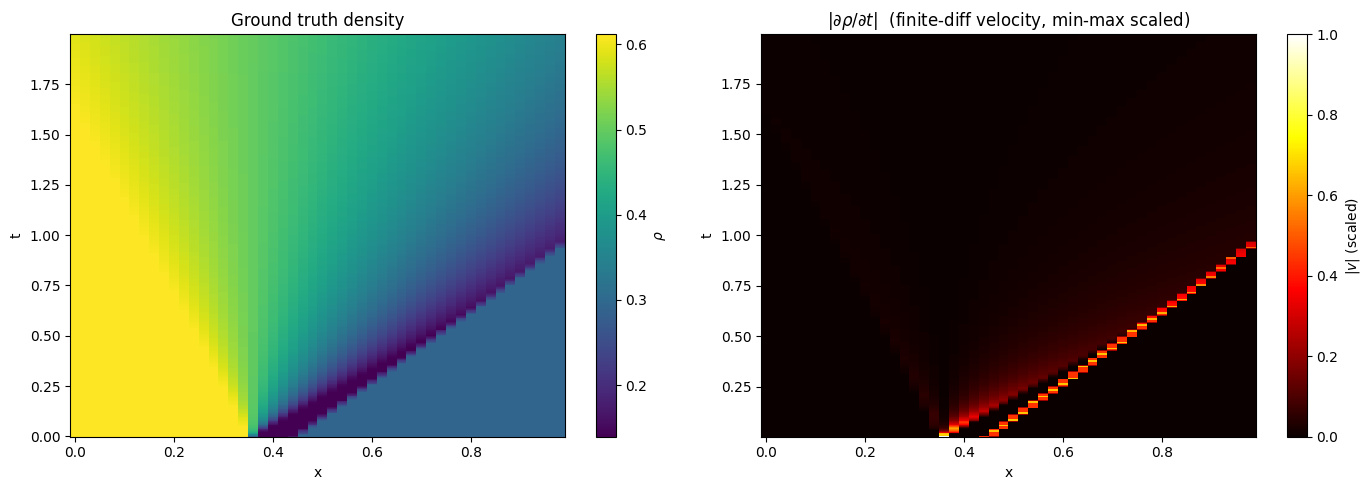

Velocity shape: torch.Size([498, 50])
Max |v|: 8.7129, Mean |v|: 0.1359
Scaled range: [0.0000, 1.0000]


In [4]:
"""Cell 3b: Velocity (finite differences) grid vs ground truth.

Compute the velocity field via central finite differences:
    v = d rho / dt   (using central differences in the interior)

Then optionally min-max scale to [0, 1] for visualisation.
"""

min_max_scale_vel = True  # Set to False to plot raw absolute values

# Compute velocity via central finite differences: (nt, nx) -> (nt-2, nx)
drho_dt = (grid[2:, :] - grid[:-2, :]) / (2 * dt)  # central differences

# Interior time array (drops first and last time step)
t_interior_v = t[1:-1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ground truth density
im0 = axes[0].pcolormesh(x, t, grid.numpy(), shading="auto", cmap="viridis")
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_title("Ground truth density")
fig.colorbar(im0, ax=axes[0], label=r"$\rho$")

# Velocity
vel_abs = drho_dt.abs().numpy()
if min_max_scale_vel:
    vel_min, vel_max = vel_abs.min(), vel_abs.max()
    vel_plot = (vel_abs - vel_min) / (vel_max - vel_min)
    plot_kwargs = dict(vmin=0, vmax=1)
    cbar_label = r"$|v|$ (scaled)"
    title_suffix = "  (finite-diff velocity, min-max scaled)"
else:
    vel_plot = vel_abs
    plot_kwargs = {}
    cbar_label = r"$|v|$"
    title_suffix = "  (finite-diff velocity)"
im1 = axes[1].pcolormesh(
    x, t_interior_v, vel_plot,
    shading="auto", cmap="hot",
    **plot_kwargs,
)
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_title(
    r"$|\partial\rho / \partial t|$"
    + title_suffix
)
fig.colorbar(im1, ax=axes[1], label=cbar_label)

fig.tight_layout()
plt.show()

print(f"Velocity shape: {drho_dt.shape}")
print(f"Max |v|: {vel_abs.max():.4f}, Mean |v|: {vel_abs.mean():.4f}")
if min_max_scale_vel:
    vel_scaled = (vel_abs - vel_abs.min()) / (vel_abs.max() - vel_abs.min())
    print(f"Scaled range: [{vel_scaled.min():.4f}, {vel_scaled.max():.4f}]")

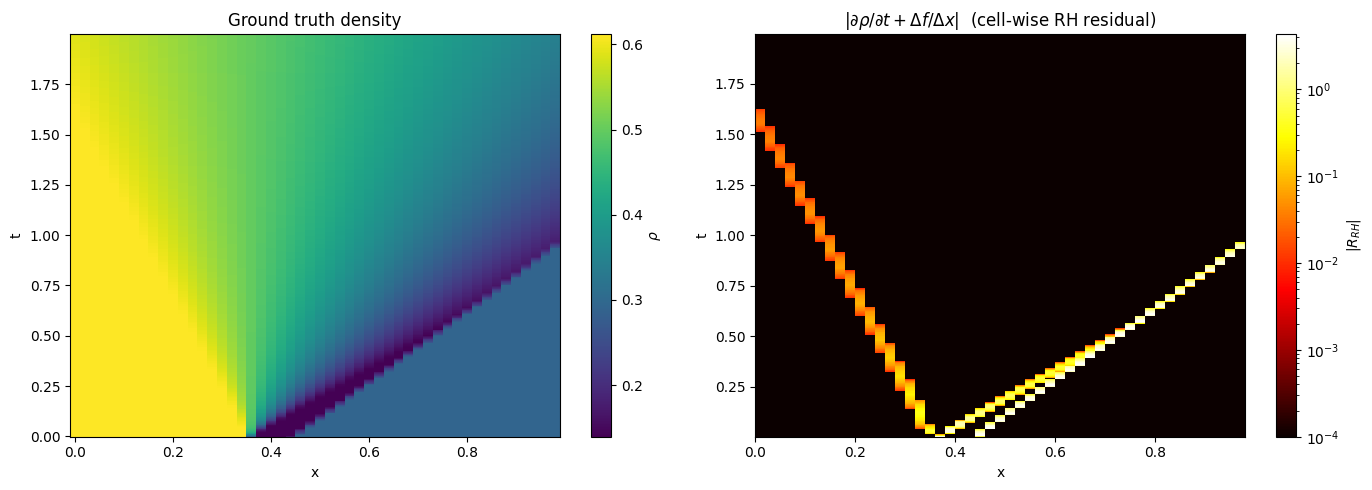

RH residual shape: torch.Size([498, 49])  (nt-2, nx-1)
Max |R|: 4.307541, Mean |R|: 0.027883

RH speed range: [-0.2237, 0.7210]
Density jump |u_R - u_L| max: 0.2924


In [13]:
"""Cell 4: Cell-wise RH residual between neighboring cells.

For each cell (n, j) and its right neighbor (n, j+1), compute the
finite-volume conservation residual:
    R_j = drho/dt + (f(u_{j+1}) - f(u_j)) / dx

This is the interface-based form of the RH condition:
- Smooth regions: R ≈ 0 (conservation law satisfied pointwise)
- Shock locations: R >> 0 (pointwise PDE breaks down; RH jump applies)

Unlike Cell 3 (central differences for both time and space), this uses
forward spatial differences (interface fluxes), which resolves shocks
more sharply.
"""

from losses.flux import greenshields_flux, compute_shock_speed

# Compute Greenshields flux f(rho) = rho*(1 - rho) at all grid points
flux = greenshields_flux(grid)  # (nt, nx)

# Time derivative: central differences at interior time steps
drho_dt = (grid[2:, :] - grid[:-2, :]) / (2.0 * dt)  # (nt-2, nx)

# Spatial flux derivative: forward differences (interface-based)
# (f(u_{j+1}) - f(u_j)) / dx at each interface j+1/2
df_dx_fwd = (flux[1:-1, 1:] - flux[1:-1, :-1]) / dx  # (nt-2, nx-1)

# Conservation / RH residual at each cell-interface pair
rh_residual = drho_dt[:, :-1] + df_dx_fwd  # (nt-2, nx-1)
eps = 1e-2
rh_residual = torch.where(rh_residual < eps, 1e-10, rh_residual)

# RH shock speed at each interface: s = 1 - u_L - u_R
u_L = grid[1:-1, :-1]  # (nt-2, nx-1)
u_R = grid[1:-1, 1:]   # (nt-2, nx-1)
rh_speed = compute_shock_speed(u_L, u_R)  # (nt-2, nx-1)


# Interface midpoint coordinates
x_mid = (x[:-1] + x[1:]) / 2  # (nx-1,)
t_interior = t[1:-1]           # (nt-2,)

# -- Plot ---------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: GT density
im0 = axes[0].pcolormesh(x, t, grid.numpy(), shading="auto", cmap="viridis")
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_title("Ground truth density")
fig.colorbar(im0, ax=axes[0], label=r"$\rho$")

# Right: |RH residual| heatmap (log scale)
rh_abs = rh_residual.abs().detach().numpy()
im1 = axes[1].pcolormesh(
    x_mid, t_interior, rh_abs,
    shading="auto", cmap="hot",
    norm=plt.matplotlib.colors.LogNorm(
        vmin=max(rh_abs[rh_abs > 0].min(), 1e-4),
        vmax=rh_abs.max(),
    ),
)
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_title(
    r"$|\partial\rho/\partial t + \Delta f / \Delta x|$"
    "  (cell-wise RH residual)"
)
fig.colorbar(im1, ax=axes[1], label=r"$|R_{RH}|$")

fig.tight_layout()
plt.show()

print(f"RH residual shape: {rh_residual.shape}  (nt-2, nx-1)")
rh_abs_t = torch.from_numpy(rh_abs)
print(f"Max |R|: {rh_abs_t.max():.6f}, Mean |R|: {rh_abs_t.mean():.6f}")
print(f"\nRH speed range: [{rh_speed.min():.4f}, {rh_speed.max():.4f}]")
print(f"Density jump |u_R - u_L| max: {(u_R - u_L).abs().max():.4f}")

In [ ]:
"""Cell 6: Entropy condition + shock proximity vs ground truth.

Three-column visualisation:
  1. Ground truth density
  2. Lax entropy condition  (is_shock boolean at interfaces)
  3. Shock proximity field   exp(-dist_to_nearest_shock / sigma)
"""

# --- Entropy condition at every interface ---
rho_left = grid[:, :-1].numpy()   # (nt, nx-1)
rho_right = grid[:, 1:].numpy()   # (nt, nx-1)

char_left = 1.0 - 2.0 * rho_left
char_right = 1.0 - 2.0 * rho_right
shock_speed_arr = 1.0 - rho_left - rho_right

is_shock = (char_left > shock_speed_arr) & (shock_speed_arr > char_right)  # (nt, nx-1)

# Interface midpoint x-coordinates
x_mid = (x[:-1] + x[1:]) / 2  # (nx-1,)

# --- Shock proximity field (inlined from data_processing.compute_shock_proximity) ---
sigma = 0.02
x_interfaces = np.arange(1, nx) * dx     # (nx-1,)
x_cells = (np.arange(nx) + 0.5) * dx     # (nx,)
proximity_2d = np.zeros((nt, nx), dtype=np.float32)

for ti in range(nt):
    shock_mask = is_shock[ti]
    if not shock_mask.any():
        continue
    shock_positions = x_interfaces[shock_mask]
    dists = np.abs(x_cells[:, None] - shock_positions[None, :])  # (nx, n_shocks)
    min_dist = dists.min(axis=1)
    proximity_2d[ti] = np.exp(-min_dist / sigma)

# --- Plot: 3 columns ---
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# 1) Ground truth density
im0 = axes[0].pcolormesh(x, t, grid.numpy(), shading="auto", cmap="viridis")
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_title("Ground truth density")
fig.colorbar(im0, ax=axes[0], label=r"$\rho$")

# 2) Entropy condition (boolean shock mask)
im1 = axes[1].pcolormesh(
    x_mid, t, is_shock.astype(float),
    shading="auto", cmap="hot", vmin=0, vmax=1,
)
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_title("Lax entropy condition (shock interfaces)")
fig.colorbar(im1, ax=axes[1], label="is_shock")

# 3) Shock proximity field
im2 = axes[2].pcolormesh(
    x, t, proximity_2d,
    shading="auto", cmap="hot", vmin=0, vmax=1,
)
axes[2].set_xlabel("x")
axes[2].set_ylabel("t")
axes[2].set_title(rf"Shock proximity ($\sigma$={sigma})")
fig.colorbar(im2, ax=axes[2], label=r"$\exp(-d/\sigma)$")

fig.tight_layout()
plt.show()

print(f"Entropy shocks detected: {is_shock.sum()} interfaces out of {is_shock.size}")
print(f"Proximity range: [{proximity_2d.min():.4f}, {proximity_2d.max():.4f}]")
print(f"Proximity sigma: {sigma}")